In [1]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

%config Completer.use_jedi = False # make autocompletion works in jupyter

tf.__version__

'2.4.1'

In [2]:
import argparse
import numpy as np
import pandas as pd
from pathlib import Path

args = argparse.Namespace()

args.n_splits = 5
args.n_jobs = -1
args.val_fraction = 0.1
args.epochs = 50
args.seed=101
args.reproducibility = True

args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()
args.predictions_folder = Path('../predictions/best')
args.models_folder = Path('../models/best')

args.model_name = 'best.hdf5'

args.predictions_folder.mkdir(parents=True, exist_ok=True) 
args.models_folder.mkdir(parents=True, exist_ok=True) 
args.run_baseline = 0
args.run_transfer = 1
args.run_augment = 0
args.run_ensemble = 0

In [3]:
import tensorflow as tf
import numpy as np


def reproducibility():
    if args.reproducibility:
        np.random.seed(args.seed)
        tf.random.set_seed(args.seed)

reproducibility()

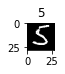

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def draw_digit(pixels_2d, label=None, size_inches=None):
    fig, ax = plt.subplots()
    if label is not None:
        ax.set_title(label)
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    imgplot = ax.imshow(pixels_2d, cmap='gray')

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
draw_digit(pixels_2d, label, (0.5, 0.5))

In [5]:
import sklearn.utils.multiclass

X_train_full = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1) / 255.0
Y_train_full = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_train_full = args.labels.to_numpy()
X_test = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1) / 255.0

log.info('X_train_full.shape: %s', repr(X_train_full.shape))
# log.info('X[0][14][14]: %s', X[0][14][14])

log.info('Y_train_full.shape: %s', repr(Y_train_full.shape))
# log.info('y[0], %s', y[0])
log.info('Type of target Y_train_full: %s', repr(sklearn.utils.multiclass.type_of_target(Y_train_full)))

log.info('y_train_full.shape: %s', repr(y_train_full.shape))
# log.info('y_sparse: %s', repr(y_sparse))
# log.info('y_sparse[0]: %s', y_sparse[0])
log.info('Type of target y_train_full: %s', repr(sklearn.utils.multiclass.type_of_target(y_train_full)))

def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Val'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()
    
def csv_predictions(predictions, filename):
    log.debug('predictions.shape: %s', repr(predictions.shape))
    predictions_classes = np.argmax(predictions, axis=1)
    csv_predictions_categorical(predictions_classes, filename)

def csv_predictions_categorical(predictions_classes, filename):
    image_ids = np.arange(1, len(predictions_classes) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_classes})
    filepath = args.predictions_folder/filename
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)


2021-06-02 17:46:00,680 : INFO : X_train_full.shape: (42000, 28, 28, 1)
2021-06-02 17:46:00,681 : INFO : Y_train_full.shape: (42000, 10)
2021-06-02 17:46:00,686 : INFO : Type of target Y_train_full: 'multilabel-indicator'
2021-06-02 17:46:00,687 : INFO : y_train_full.shape: (42000,)
2021-06-02 17:46:00,688 : INFO : Type of target y_train_full: 'multiclass'


### Baseline

In [6]:
from tensorflow import keras

def baseline_model():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    monitor='val_loss'
    early_stopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='auto', restore_best_weights=True, verbose=1)
    reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, min_delta=1e-4, mode='auto', verbose=1)
    
    return model, [early_stopping, reduce_lr_on_plateau]

def baseline():
    reproducibility()
    model, callbacks = baseline_model()
    
    history = model.fit(X_train_full, y_train_full, validation_split=args.val_fraction, epochs=args.epochs, 
                        callbacks=callbacks, verbose=1)
    plot_history(history)
    
    predictions = model.predict(X_test)
    csv_predictions(predictions, 'baseline.csv')

if args.run_baseline:
    baseline()

| Model | Params  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | No dropout, early_stopping='val_acc' | 0.99017 | 0.9924 |
| Baseline | Dropout=0.4, early_stopping='val_acc' | 0.99200 | 0.9931 |
| Baseline | Dropout=0.4, Batch normalization, early_stopping='val_acc'  | 0.99278 |  0.9943 |
| Baseline | Dropout=0.4, Batch normalization, early_stopping='val_loss'  | 0.99389 |  0.9948 |


##### Other results
| Model | Params  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | Dropout=0.25 (after 2 first conv) | 0.99150 | 0.9929 |
| Baseline | Dropout=0.5 (after 2 first conv) | 0.99178 | 0.9924 |
| Baseline | Dropout=0.5  | 0.98867 | 0.9912 |
| Baseline | Dropout=0.3  | 0.99182 |  0.9936 |
| Baseline | Dropout=0.4 batch normalization before activation  | 0.99275 |  0.9929 |
| Baseline | Dropout=0.4 batch normalization he normal | 0.99250 |  0.9940 |

### Transfer learning

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Epoch 1/5
1182/1182 [==============================] - 1467s 1s/step - loss: 2.1912 - accuracy: 0.2626 - val_loss: 1.8106 - val_accuracy: 0.4967
Epoch 2/5
1182/1182 [==============================] - 1470s 1s/step - loss: 1.7930 - accuracy: 0.5348 - val_loss: 1.7217 - val_accuracy: 0.6157
Epoch 3/5
1182/1182 [==============================] - 1676s 1s/step - loss: 1.7098 - accuracy: 0.6163 - val_loss: 1.6698 - val_accuracy: 0.6145
Epoch 4/5
1182/1182 [==============================] - 1712s 1s/step - loss: 1.6636 - accuracy: 0.6431 - val_loss: 1.6374 - val_accuracy: 0.6779
Epoch 5/5
1182/1182 [==============================] - 1961s 2s/step - loss: 1.6316 - accuracy: 0.6601 - val_loss: 1.6179 - val_accuracy: 0.6429


2021-06-02 20:04:08,075 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


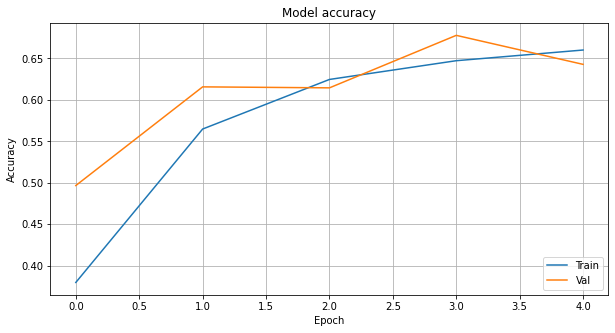

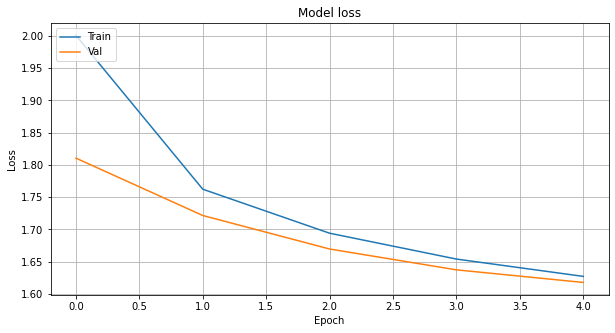

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Epoch 1/5
1182/1182 [==============================] - 7091s 6s/step - loss: 0.4133 - accuracy: 0.8823 - val_loss: 6.3553 - val_accuracy: 0.1083
Epoch 2/5
1182/1182 [==============================] - 38557s 33s/step - loss: 0.0328 - accuracy: 0.9910 - val_loss: 3.6114 - val_accuracy: 0.3081
Epoch 3/5
1182/1182 [==============================] - 7084s 6s/step - loss: 0.0256 - accuracy: 0.9933 - val_loss: 3.3072 - val_accuracy: 0.3648
Epoch 4/5
1182/1182 [==============================] - 7322s 6s/step - loss: 0.0236 - accuracy: 0.9940 - val_loss: 0.4069 - val_accuracy: 0.8990
Epoch 5/5
1182/1182 [==============================] - 7396s 6s/step - loss: 0.0216 - accuracy: 0.9941 - val_loss: 0.1123 - val_accuracy: 0.9662


2021-06-03 14:48:19,973 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


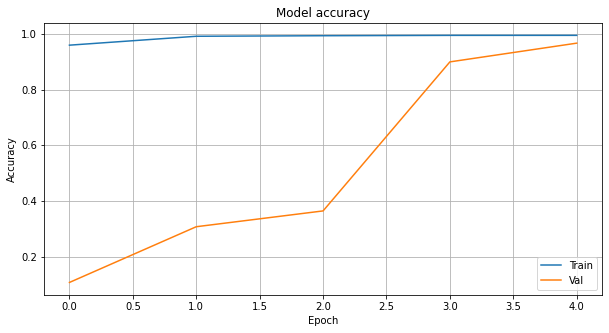

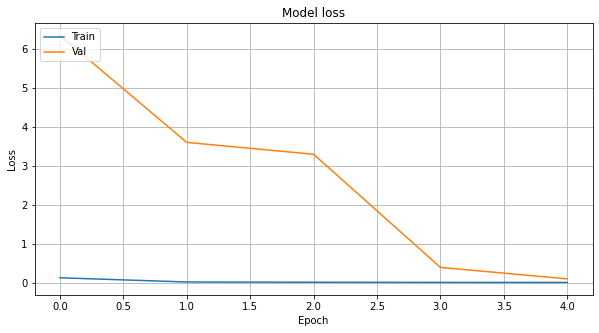

2021-06-03 15:04:25,186 : INFO : Saved file: ../predictions/best/transfer.csv


In [7]:
import matplotlib.pyplot as plt

def transfer_learning():
    batch_size = 32
    epochs = 5
    train_idx = len(X_train_full) - int(len(X_train_full) * args.val_fraction)
    val_idx = train_idx
    
#     train_idx = 50
#     val_idx = len(X_train_full) - train_idx
    
    def preprocess_image(image):
        resized_image = tf.image.resize(image, [224, 224])
        rgb_image = tf.image.grayscale_to_rgb(resized_image)
        final_image = keras.applications.xception.preprocess_input(rgb_image)
        return final_image
        
    def preprocess(image, label):
            return preprocess_image(image), label
        
    def dataset(x, preprocess_func=preprocess):
        def debug_data(data):
            for d in data:
                print(d)
                fig, ax = plt.subplots()
                imgplot = ax.imshow(d[0][0])
                break
        data = tf.data.Dataset.from_tensor_slices(x).shuffle(len(X_train_full)).map(preprocess_func).batch(batch_size).prefetch(1)
        return data
    
    def build_model():
        base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
        avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
        output = keras.layers.Dense(10, activation='softmax')(avg)
        model = keras.Model(inputs=base_model.input, outputs=output)
        return base_model, model
    
    
    def train(base_model, model, train_data, val_data, train_base=False, epochs=epochs, lr=0.2):
#         print('Start')
#         print(base_model.layers[5].weights)
#         print(model.layers[5].weights)
        for l in base_model.layers:
            l.trainable = train_base
        optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=0.01)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print(model.summary())
        history = model.fit(train_data, epochs=epochs, validation_data=val_data)
        plot_history(history)
#         print('End')
#         print(base_model.layers[5].weights)
#         print(model.layers[5].weights)
    
    train_data = dataset((X_train_full[:train_idx], y_train_full[:train_idx]))
    val_data = dataset((X_train_full[val_idx:], y_train_full[val_idx:]))
    base_model, model = build_model()
    train(base_model, model, train_data, val_data)
    train(base_model, model, train_data, val_data, train_base=True, lr=0.005)
    
    test_data = dataset(X_test, preprocess_func=preprocess_image)
    predictions = model.predict(test_data)
    csv_predictions(predictions, 'transfer.csv')

if args.run_transfer:
    transfer_learning()

| Model | Params  | Test score  | CV mean score | Val loss |
|---|---|---|---|---|
| Transfer Xception | epochs=5, lr1 (top layers) = 0.2, lr2 (all layers) =0.005 | 0.09728 | 0.9662 | 0.1123 |

### Data augmentation

In [ ]:
from sklearn.model_selection import train_test_split

def data_augmentator():
        datagen = keras.preprocessing.image.ImageDataGenerator(
        #   shear_range=0.05,
        #   channel_shift_range=0.05,
            rotation_range=5,
            zoom_range=0.05,
            width_shift_range=0.05,
            height_shift_range=0.05)
        return datagen

def data_augmentation():
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=args.val_fraction, 
                                                      random_state=args.seed)
    datagen = data_augmentator()
#     val_modified_batch = datagen.flow(X_val, y_val, seed=args.seed).next()
#     draw_digit(val_modified_batch[0][0], val_modified_batch[1][0])
    
    train_generator = datagen.flow(X_train, y_train, seed=args.seed)
    model, callbacks = baseline_model()
    history = model.fit(train_generator, epochs=args.epochs, validation_data=(X_val, y_val), callbacks=callbacks)
    plot_history(history)
    predictions = model.predict(X_test)
    csv_predictions(predictions, 'augment.csv')

if args.run_augment:
    data_augmentation()

| Model | Params  | Test score  | CV mean score | Val loss |
|---|---|---|---|---|
| Augment run 1 | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1  | 0.99421 | 0.9936 | 0.0188|
| Augment run 2 | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1  | 0.99453 | 0.9964 | 0.0135|
| Augment run 3 | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1  | 0.99435 | 0.9948 | 0.0151|
| Augment | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=5, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05  | 0.99503 | 0.9950 | 0.0147 |
| Augment | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=2, zoom_range=0.02, width_shift_range=0.02, height_shift_range=0.02  | 0.99392 | 0.9962 | 0.0160 |
| Augment | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=7, zoom_range=0.07, width_shift_range=0.07, height_shift_range=0.07  | 0.99453 | 0.9950 | 0.0144 |
| Augment | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=5, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05  | 0.99503 | 0.9950 | 0.0147 |
| Augment | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=5, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05, channel_shift_range=0.05  | 0.99475 | 0.9950 | 0.0139 |

### Ensemble + data augmentation

In [ ]:
from collections import Counter

def ensemble(num_models=5):
    models = []
    for model_num in range(num_models):
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=args.val_fraction, 
                                                  random_state=model_num)
        datagen = data_augmentator()
        datagen.fit(X_train, seed=model_num)
        train_generator = datagen.flow(X_train, y_train, seed=args.seed)
        model, callbacks = baseline_model()
        history = model.fit(train_generator, epochs=args.epochs, validation_data=(X_val, y_val), callbacks=callbacks)
        plot_history(history)
        models.append(model)
    
    predictions_classes = []
    for model in models:
        predictions_cur = model.predict(X_test)
        predictions_classes_cur = np.argmax(predictions_cur, axis=1)
        predictions_classes.append(predictions_classes_cur)
    
    def bag_predictions(predictions_classes):
        predictions_classes_bagged = []
        predictions_classes_stacked = np.stack(predictions_classes, axis=-1)
        for prediction_i in predictions_classes_stacked:
            predictions_classes_bagged.append(Counter(prediction_i).most_common(1)[0][0])
        return predictions_classes_bagged
    
    csv_predictions = csv_predictions_categorical(bag_predictions(predictions_classes), 'ensemble-augment.csv')

if args.run_ensemble:
    ensemble()

| Model | Params  | Test score  | CV mean score | Val loss |
|---|---|---|---|---|
| Augment ensemble 5 models | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=5, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05  | 0.99517 | - | - |